# Image labeller with persistence (example)

This notebook will demonstrate the follwing:

- using the image labelling tool as an IPython Notebook plugin
- rendering labels to create edge maps and label images
- extracting images of individual objects

It will also describe the label JSON file format.

In [1]:
%matplotlib inline

import os, math

from matplotlib import pyplot as plt

from image_labelling_tool import labelling_tool

## Using the label data

You can either render the labels with the provided code or read the JSON label data directly.

### Render the labels

First, get the image 'uea_grounds_2.jpg' that comes with some labels pre-defined:

In [2]:
# Load in .JPG images from the 'images' directory.
labelled_images = labelling_tool.PersistentLabelledImage.for_directory('images', image_filename_patterns=['*.jpg'])
print('Loaded {0} images'.format(len(labelled_images)))



for limg in labelled_images:
    if os.path.basename(limg.image_path).lower() == 'uea_grounds_2.jpg':
        labelled_img = limg
        
print(labelled_img.image_path)

print(type(labelled_img))

Loaded 11 images
images/uea_grounds_2.jpg
<class 'image_labelling_tool.labelling_tool.PersistentLabelledImage'>


#### Types

`labelled_images` is a list of `PersistentLabelledImage` instances. `PersistentLabelledImage` derives from `AbsractLabelledImage`. These classes pair images with corresponding labels. `PersistentLabelledImage` transparently loads an image when accessing its pixel content and loads or save labels when they accessed or modified.

Labels are represented by the `ImageLabels` class that directly represents the labels in vector form and provides methods to work with them.

#### Get a histogram of the label classes used

We can start by getting a histogram of the classes used. The `label_class_histogram` method is defined on the `ImageLabels` class. The `AbsractLabelledImage` class wraps it:

In [3]:
labelled_img.label_class_histogram()

{'building': 1, 'tree': 4, 'lake': 1}

#### Creating a semantic segmentation map

We can create a semantic segmentation map with the `render_label_classes` method.

As seen in the *Example Tool* cell above we have three classes; `tree`, `building` and `lake`.

The `label_classes` specifies how class names should be mapped to values in the image. It can either be a dictionary of `{class_name: class_index}` or it can be a sequence of class names. Label classes not listed in `label_classes` will be ignored. For example, lets render all the labels.

In [4]:
labelled_img.labels

`class_labels` as a dictionary:

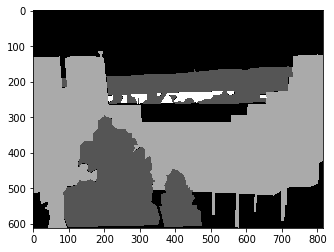

In [5]:
labels_2d = labelled_img.render_label_classes(
    label_classes={'tree' : 1, 'building' : 2, 'lake' : 3}, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

`class_labels` as a sequence:

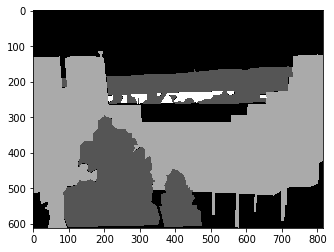

In [6]:
labels_2d = labelled_img.render_label_classes(
    label_classes=['tree', 'building', 'lake'], multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

When using a sequence for `class_labels`, re-ordering changes the label values:

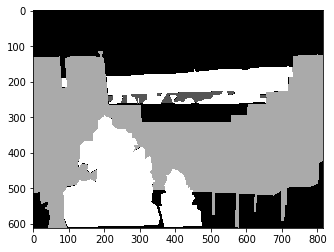

In [7]:
labels_2d = labelled_img.render_label_classes(
    label_classes=['lake', 'building', 'tree'], multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

You can render a subset of the labels used in the image; just the trees:

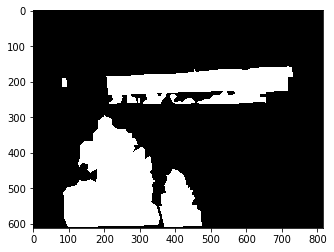

In [8]:
labels_2d = labelled_img.render_label_classes({'tree': 1}, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Again using a sequence:

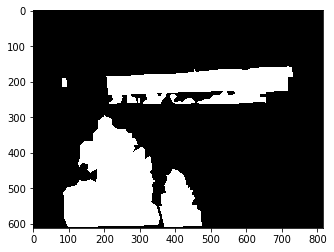

In [9]:
labels_2d = labelled_img.render_label_classes(['tree'], multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

If `label_classes` is a sequence, each item can also be a list of classes. This will result in the same value being used for multiple classes in the image. Lets render the natural featues - lake and trees - as one value and the non-natural - buildings - as another:

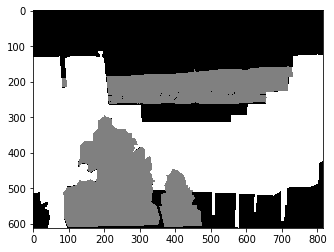

In [10]:
labels_2d = labelled_img.render_label_classes(
    label_classes=[['tree', 'lake'], 'building'], multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Setting the `fill` parameter to `False` results in outlines being rendered:

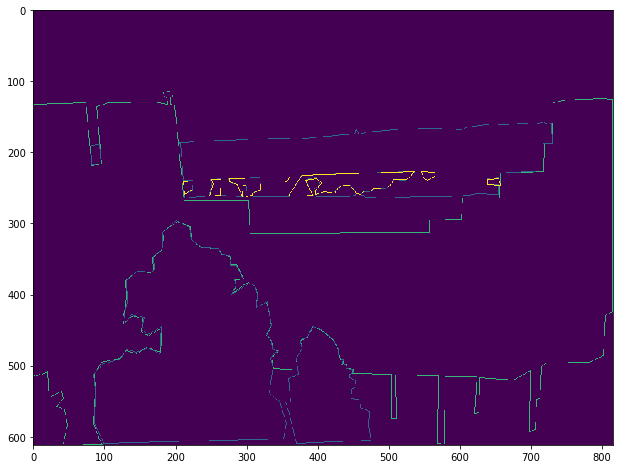

In [11]:
labels_2d = labelled_img.render_label_classes(
    label_classes={'tree' : 1, 'building' : 2, 'lake' : 3}, multichannel_mask=False, fill=False)
plt.figure(figsize=(12,8))
plt.imshow(labels_2d)
plt.show()

Setting the `multichannel_mask` parameter to `True` will result in a multi-channel mask image in the form of a 3D array. It will have one channel for each item in `label_classes`. Pixels will have either a value of `0` or `1` in a given channel indicating presence of a label in that class:

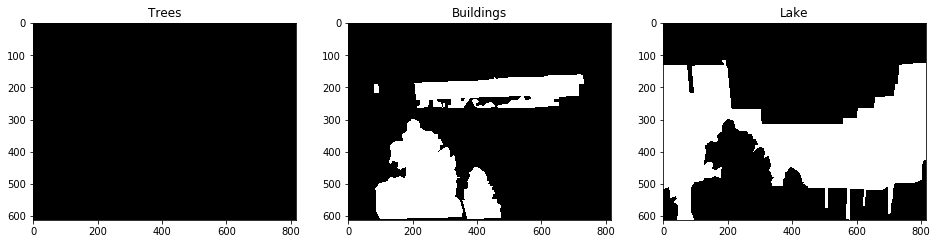

In [12]:
labels_2dn = labelled_img.render_label_classes(label_classes={'tree' : 1, 'building' : 2, 'lake' : 3},
                                               multichannel_mask=True)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.title('Trees')
plt.imshow(labels_2dn[:,:,0], cmap='gray')

plt.subplot(1,3,2)
plt.title('Buildings')
plt.imshow(labels_2dn[:,:,1], cmap='gray')

plt.subplot(1,3,3)
plt.title('Lake')
plt.imshow(labels_2dn[:,:,2], cmap='gray')
plt.show()

#### Rendering individual labels

The `render_label_instances` method assigns a different label value to each individual object. It returns a tuple of two values; the first is a label image as a 2D array where each pixel gives the index of the label and the second is a 1D array that gives the class index of each label. The `label_classes` parameter functions as with the `render_label_classes` method.

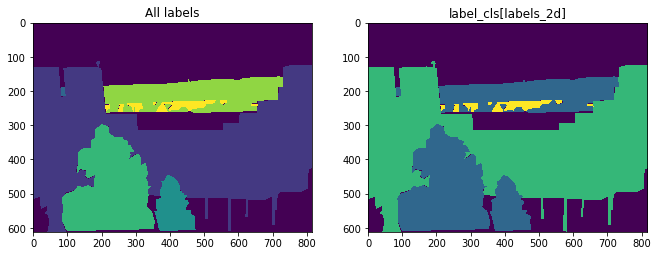

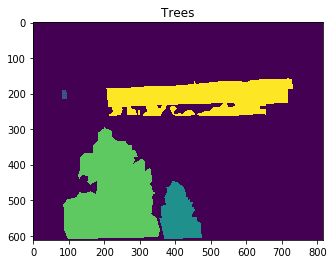

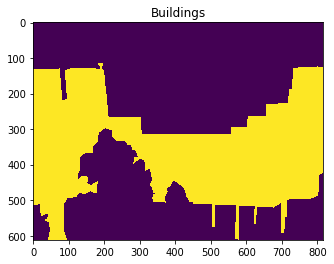

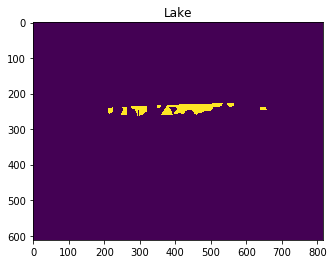

In [13]:
labels_2d, label_cls = labelled_img.render_label_instances(label_classes={'tree' : 1, 'building' : 2, 'lake' : 3})
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('label_cls[labels_2d]')
plt.imshow(label_cls[labels_2d])
plt.show()

# trees
labels_2d, label_cls = labelled_img.render_label_instances(label_classes={'tree' : 1})
plt.figure()
plt.title('Trees')
plt.imshow(labels_2d)
plt.show()
# buildings
labels_2d, label_cls = labelled_img.render_label_instances(label_classes={'building' : 1})
plt.figure()
plt.title('Buildings')
plt.imshow(labels_2d)
plt.show()
# lake
labels_2d, label_cls = labelled_img.render_label_instances(label_classes={'lake' : 1})
plt.figure()
plt.title('Lake')
plt.imshow(labels_2d)
plt.show()


Setting the `fill` parameter to `False` results in an outline image as before:

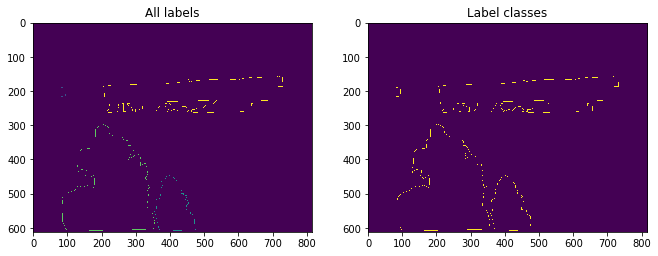

In [14]:
# Only render trees so that we can show one large image, otherwise the 1-pixel-wide outlines
# will be difficult to see:
labels_2d, label_cls = labelled_img.render_label_instances(label_classes={'tree' : 1}, fill=False)
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('Label classes')
plt.imshow(label_cls[labels_2d])
plt.show()


Setting the `multichannel_mask` parameter to `True` results in an image with one channel per label. This would
be suitable for training the [PyTorch Mask-RCNN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) model:

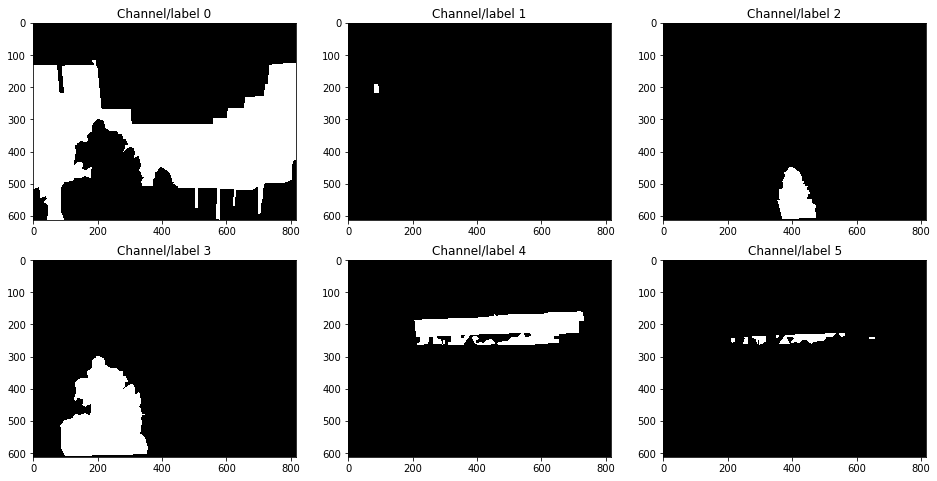

In [15]:
labels_2d, label_cls = labelled_img.render_label_instances(
    label_classes={'tree' : 1, 'building' : 2, 'lake' : 3}, multichannel_mask=True)

COLUMNS = 3
ROWS = labels_2d.shape[2] // COLUMNS
if labels_2d.shape[2] % COLUMNS > 0:
    ROWS += 1

plt.figure(figsize=(16, 4 * ROWS))
for i in range(labels_2d.shape[2]):
    plt.subplot(ROWS, COLUMNS, i + 1)
    plt.title('Channel/label {}'.format(i))
    plt.imshow(labels_2d[:, :, i], cmap='gray')
plt.show()

#### Extracting images of labelled objects

The `extract_label_images` method extracts the pixels covered by each individual labelled object from the original image. The `label_class_set` parameter specifies the classes of objects that should be rendered; objects whoses classes are not listed are not rendered. It can also be `None` to render all objects of all classes. It returns a list of images:

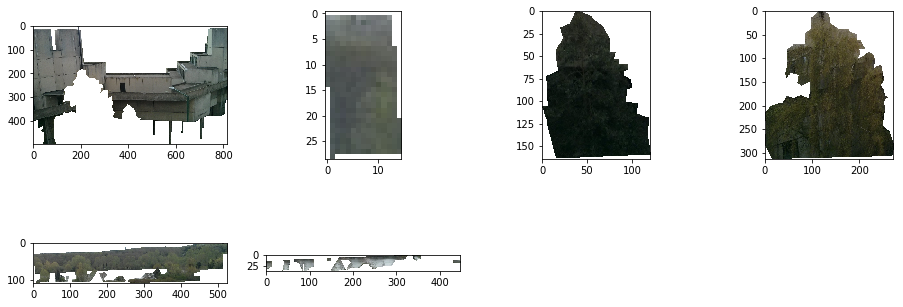

In [16]:
# Render all objects:
object_images = labelled_img.extract_label_images(label_class_set=None)
n_cols = 4
n_rows = int(math.ceil(float(len(object_images)) / n_cols))
plt.figure(figsize=(16,n_rows*3))
    
for i, img in enumerate(object_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
plt.show()

Extract objects separately by class:

Extracted objects of class 'tree':


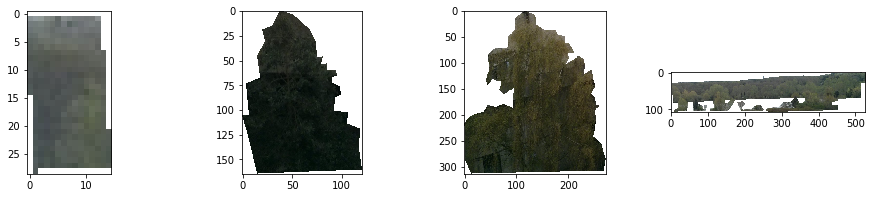

Extracted objects of class 'lake':


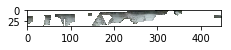

Extracted objects of class 'building':


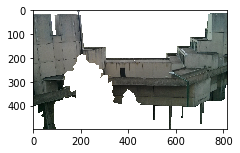

In [17]:
for cls in ['tree', 'lake', 'building']:
    print('Extracted objects of class \'{0}\':'.format(cls))
    object_images = labelled_img.extract_label_images(label_class_set=[cls])
    n_cols = 4
    n_rows = int(math.ceil(float(len(object_images)) / n_cols))
    plt.figure(figsize=(16,n_rows*3))

    for i, img in enumerate(object_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
    plt.show()

### Label data API

The label data access API will now be demonstrated.

First, load the labels from the JSON file:

In [18]:
labels_path = os.path.join('images', 'uea_grounds_2__labels.json')
labels = labelling_tool.ImageLabels.from_file(labels_path)

Show the first label:

In [19]:
print('len(labels)={}'.format(len(labels)))
print('type(labels[0])={}'.format(type(labels[0])))
print('labels[0].object_id={}'.format(labels[0].object_id))
print('labels[0].classification={}'.format(labels[0].classification))
print('labels[0].regions={}'.format(labels[0].regions))
print('labels[0]={}'.format(labels[0]))

len(labels)=6
type(labels[0])=<class 'image_labelling_tool.labelling_tool.PolygonLabel'>
labels[0].object_id=1
labels[0].classification=building
labels[0].regions=[array([[ 8.15656799e+02,  1.25164574e+02],
       [ 8.00462830e+02,  1.24957329e+02],
       [ 7.50321472e+02,  1.26276833e+02],
       [ 7.31518494e+02,  1.30565231e+02],
       [ 7.30760132e+02,  1.88298508e+02],
       [ 7.19273132e+02,  1.88011322e+02],
       [ 7.18124451e+02,  2.27354248e+02],
       [ 6.57437134e+02,  2.29559341e+02],
       [ 6.56001282e+02,  2.64594635e+02],
       [ 6.04596985e+02,  2.64307465e+02],
       [ 6.02873962e+02,  2.94747986e+02],
       [ 5.57787537e+02,  2.95609497e+02],
       [ 5.57787537e+02,  3.13127136e+02],
       [ 3.05853027e+02,  3.14466400e+02],
       [ 3.03525970e+02,  2.68869049e+02],
       [ 2.80264832e+02,  2.68294708e+02],
       [ 2.38624527e+02,  2.68581879e+02],
       [ 2.12646286e+02,  2.68312469e+02],
       [ 1.99152756e+02,  1.34682953e+02],
       [ 1.93929443

### JSON Label Format

The label data is in JSON form. An example file is included in the `images` directory. The format of the file will now be described.

```
<root>: 

{
    image_filename: <image filename as string>,
    complete: <boolean indicating if the user has marked the labels as complete>
    labels: [
        <label_object 0>,
        <label_object 1>,
        ...
        <label_object N>
    ]
}


<label_object -- where label_type=polygon>:
{
    label_class: <label class as string; identifiers used above to identify label classes>
    label_type: 'polygon',
    regions: [
        [
            <vector2 0>,
            <vector2 1>,
            ...
            <vector2 N>
        ],
        [
            <vector2 0>,
            <vector2 1>,
            ...
            <vector2 N>
        ],

    ]
}


<vector2>:
{
    x: <x-co-ordinate as float>,
    y: <y-co-ordinate as float>
}
```
